<center> <span style="color:indigo">Machine Learning e Inferencia Bayesiana</span> </center> 

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5e/Logo-cucea.png" alt="Drawing" style="width: 600px;"/>
</center>
    
<center> <span style="color:DarkBlue">  Tema 4: Probabilidad, Naive Bayes, datos de emails spam </span>  </center>
<center> <span style="color:Blue"> M. en C. Iván A. Toledano Juárez </span>  </center>

## Clasificación de SPAM en mensajes SMS

En este notebook trabajaremos con un conjunto de datos reales de mensajes de texto (SMS), recolectados con el objetivo de entrenar y evaluar modelos de *Machine Learning* que permitan **clasificar automáticamente si un mensaje es SPAM o no**.

El conjunto de datos fue tomado del sitio web [grumbletext.co.uk](http://www.grumbletext.co.uk/), y fue utilizado en el artículo académico:

> Almeida, T.A., Gómez Hidalgo, J.M., Yamakami, A. (2011).  
> *Contributions to the Study of SMS Spam Filtering: New Collection and Results*.  
> Proceedings of the ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA.

La estructura de los datos es sencilla y directa:
- Una columna indica si el mensaje es **spam** o **ham** (no spam).
- La otra contiene el **contenido completo del mensaje SMS**.

Este conjunto es ampliamente utilizado en ejemplos didácticos y tareas de clasificación binaria de texto. La estructura y el objetivo coinciden con escenarios reales de clasificación automática de correos o mensajes maliciosos, lo cual lo convierte en un excelente punto de partida para explorar técnicas como **Naive Bayes**.

> Esta implementación está inspirada en un ejemplo de la comunidad de Kaggle:  
> [Naive Bayes + SVM Spam Filtering](https://www.kaggle.com/code/pablovargas/naive-bayes-svm-spam-filtering) por Pablo Vargas.



## Importación de Librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

## Importación de datos

In [16]:
df_sms = pd.read_csv('../data/spam/spam.csv', encoding = 'latin-1')

# Quitamos las últimas columnas que no tienen nada
df_sms = df_sms.drop(['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'], axis = 1)

# Renombramos las columnas
df_sms.columns = ['class','text']

df_sms.head(10)

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [17]:
df_sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


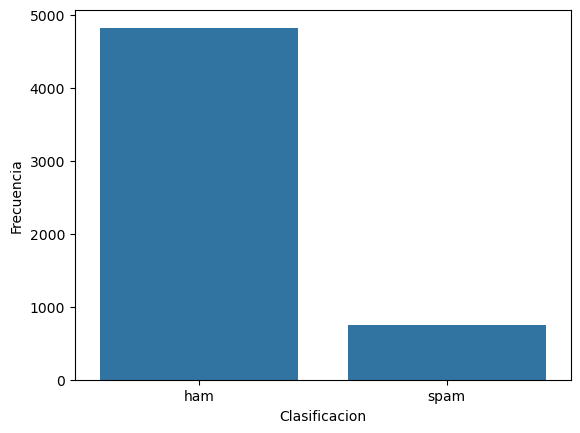

In [10]:
# Observamos qué porcentaje de todos los datos pertenecen a spam
# Gráfico de barras

sns.countplot(data = df_sms,
            x = 'class')

plt.xlabel('Clasificacion')
plt.ylabel('Frecuencia')
plt.show()

/var/folders/kk/gbkrt22x1jn_jfmqkw6krfw00000gn/T/ipykernel_26713/3227900534.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  data_class = pd.value_counts(df_sms['class']).to_frame()


,count
class,
ham,4825
spam,747


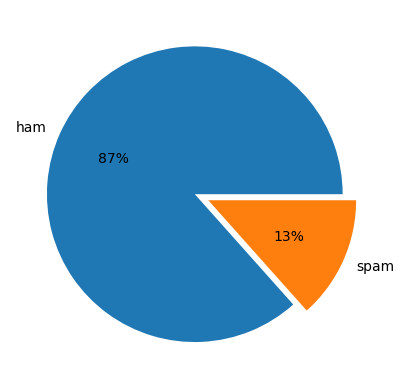

In [13]:
# Gráfico circular
data_class = pd.value_counts(df_sms['class']).to_frame()
display(data_class)

explode = [0, 0.1]

plt.pie(data_class['count'], labels=data_class.index,
        explode=explode, autopct='%.0f%%')

plt.show()

## Funciones

La siguiente función se encarga de limpiar texto removiendo cualquier carácter no alfanumérico (como signos de puntuación o símbolos especiales) y convirtiendo todo el contenido a minúsculas. Esta limpieza básica es útil en tareas de procesamiento de lenguaje natural (NLP), ya que permite normalizar las palabras y reducir la variabilidad del texto antes de aplicar técnicas como la tokenización o el cálculo de frecuencias.


In [18]:
# Esta funcion remueve caracteres alfanumericos de un string y lo pasa a minusculas

def removenonalphanum(word):
    for char in word:
        if not char.isalnum():
            word = word.replace(char, "")
    return word.lower()

# Histograma de palabras

In [19]:
# Creamos dos dataframes, uno con spam y otro con ham
df_sms_ham = df_sms[df_sms['class'] == 'ham']
df_sms_spam = df_sms[df_sms['class'] == 'spam']

In [20]:
## Dataframe con las palabras más frecuentes.

list_sms_ham = [] # iniciar lista donde ser guardan los sms

for text in df_sms_ham['text']: # iterar sobre todos los textos ham
    list_sms_ham.append(text.split())
    
# aplanamos lista y además quitamos caracteres alfanumericos
#list_sms_ham = [removenonalphanum(item) for sublist in list_sms_ham for item in sublist]
list_sms_ham = [item for sublist in list_sms_ham for item in sublist]

# pasamos a un objetos Series de Pandas para hacer la agrupación
series_sms_ham = pd.Series(list_sms_ham)

df_ham_count = series_sms_ham.value_counts().to_frame().head(15)

df_ham_count

,count
to,1530
you,1458
I,1436
the,1019
a,969
and,738
i,736
in,734
u,645
is,638


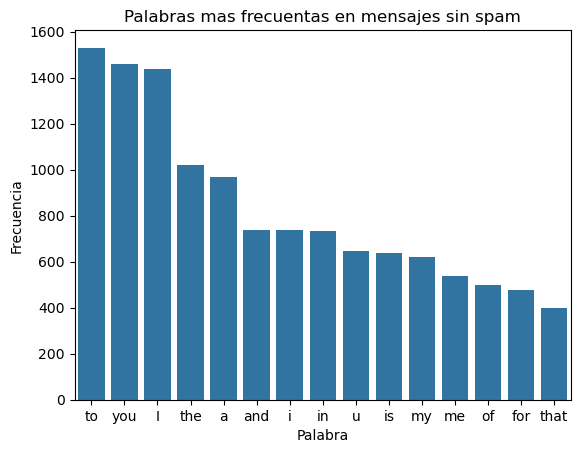

In [22]:
sns.barplot(x=df_ham_count.index,
            y=df_ham_count['count'])
plt.title('Palabras mas frecuentas en mensajes sin spam')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.show()

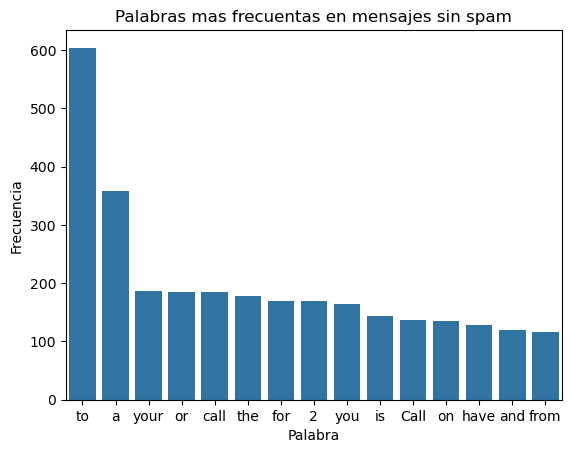

In [24]:
# lo mismo para spam

## Dataframe con las palabras más frecuentes.

list_sms_spam = [] # iniciar lista donde ser guardan los sms

for text in df_sms_spam['text']: # iterar sobre todos los textos ham
    list_sms_spam.append(text.split())
    
# aplanamos lista y además quitamos caracteres alfanumericos
#list_sms_ham = [removenonalphanum(item) for sublist in list_sms_ham for item in sublist]
list_sms_spam = [item for sublist in list_sms_spam for item in sublist]

# pasamos a un objetos Series de Pandas para hacer la agrupación
series_sms_spam = pd.Series(list_sms_spam)

df_spam_count = series_sms_spam.value_counts().to_frame().head(15)

sns.barplot(x=df_spam_count.index,
            y=df_spam_count['count'])
plt.title('Palabras mas frecuentas en mensajes sin spam')
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')
plt.show()

## Remover palabras comunes del lenguaje (stopwords) y vectorización del texto

En esta etapa del preprocesamiento, eliminamos las **palabras más comunes del lenguaje** —conocidas como *stopwords*— como `"to"`, `"is"`, `"the"`, entre otras. Estas palabras, aunque frecuentes, suelen aportar poca información útil para tareas de clasificación, ya que no ayudan a distinguir entre mensajes SPAM y NO SPAM.

Una vez limpio el texto, procedemos a representar los datos de forma numérica utilizando técnicas de vectorización provistas por `scikit-learn`. 

Utilizamos `CountVectorizer` de `scikit-learn` para transformar los mensajes SMS en una matriz de características numéricas. Este método construye una representación tipo *bag-of-words*, en la que cada columna corresponde a una palabra del vocabulario (excluyendo las *stopwords* en inglés), y cada fila representa un mensaje. El valor en cada celda indica cuántas veces aparece una palabra en el mensaje correspondiente.

Esta representación es esencial para poder aplicar modelos de clasificación como Naive Bayes, ya que transforma el texto en un formato que los algoritmos pueden procesar directamente.


In [32]:
df_sms = pd.read_csv('../data/spam/spam.csv', encoding = 'latin-1')
df_sms = df_sms.drop(['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'], axis = 1)
df_sms.columns = ['class','text']

In [33]:
from sklearn import feature_extraction, model_selection, naive_bayes, metrics

f = feature_extraction.text.CountVectorizer(stop_words = 'english')
X = f.fit_transform(df_sms["text"])
np.shape(X)

(5572, 8404)

In [34]:
X.data

array([1, 1, 1, ..., 1, 1, 1])

In [35]:
# Las etiquetas ham y spam se pasan a variables binarias

# Además, se crea set de entrenamiento y validacion

df_sms["class"]=df_sms["class"].map({'spam':1,'ham':0})
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, df_sms["class"], test_size=0.33, random_state=42)
print([np.shape(X_train), np.shape(X_test)])

[(3733, 8404), (1839, 8404)]


## Naive Bayes Classifier

In [37]:
list_alpha = np.arange(1/100000, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0

for alpha in list_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    count = count + 1 

In [38]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)


,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.998661,0.974443,0.920635,0.895753
1,0.11001,0.997857,0.976074,0.936508,0.893939
2,0.22001,0.997857,0.977162,0.936508,0.900763
3,0.33001,0.997589,0.977162,0.936508,0.900763
4,0.44001,0.997053,0.977162,0.936508,0.900763
5,0.55001,0.996250,0.976618,0.936508,0.897338
6,0.66001,0.996518,0.976074,0.932540,0.896947
7,0.77001,0.996518,0.976074,0.924603,0.903101
8,0.88001,0.996250,0.976074,0.924603,0.903101
9,0.99001,0.995982,0.976074,0.920635,0.906250


Estas métricas nos ayudan a evaluar el desempeño de un modelo de clasificación:

- **Accuracy (exactitud)** mide la proporción de predicciones correctas sobre el total de casos: $\frac{\text{TP} + \text{TN}}{\text{TP} + \text{FP} + \text{FN} + \text{TN}}$, lo que indica cuán a menudo el modelo acierta globalmente.

- **Precision (precisión)** evalúa la calidad de las predicciones positivas: es la proporción de verdaderos positivos entre todas las predicciones positivas, es decir, TP / (TP + FP). Nos dice cuántas de las predicciones de SPAM fueron realmente SPAM.

- **Recall (sensibilidad o cobertura)** mide qué tan bien el modelo captura todos los casos positivos reales: TP / (TP + FN). Indica cuántos mensajes SPAM reales fueron detectados por el modelo.

Estas medidas son especialmente críticas cuando las clases están desbalanceadas: un modelo puede tener alta exactitud simplemente prediciendo siempre la clase mayoritaria, mientras que la precisión y el recall ofrecen una visión más realista del desempeño para la clase minoritaria (e.g., SPAM).


In [39]:
# Se selecciona el modelo con la mejor precisión

best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

alpha             15.730010
Train Accuracy     0.979641
Test Accuracy      0.969549
Test Recall        0.777778
Test Precision     1.000000
Name: 143, dtype: float64

In [40]:
# Sin embargo hay cinco modelos que tuvieron un score 1.0 en precision

models[models['Test Precision']==1].head(n=5)


,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
143,15.73001,0.979641,0.969549,0.777778,1.0
144,15.84001,0.979641,0.969549,0.777778,1.0
145,15.95001,0.979641,0.969549,0.777778,1.0
146,16.06001,0.979373,0.969549,0.777778,1.0
147,16.17001,0.979373,0.969549,0.777778,1.0


In [41]:
# se selecciona el modelo que tenga mayor accuracy

best_index = models[models['Test Precision']==1]['Test Accuracy'].idxmax()
bayes = naive_bayes.MultinomialNB(alpha=list_alpha[best_index])
bayes.fit(X_train, y_train)
models.iloc[best_index, :]

alpha             15.730010
Train Accuracy     0.979641
Test Accuracy      0.969549
Test Recall        0.777778
Test Precision     1.000000
Name: 143, dtype: float64

## Matriz de confusión

In [42]:
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1587,0
Actual 1,56,196


In [43]:
best_model = models.iloc[best_index, :]
best_model

alpha             15.730010
Train Accuracy     0.979641
Test Accuracy      0.969549
Test Recall        0.777778
Test Precision     1.000000
Name: 143, dtype: float64

In [44]:
bayes = naive_bayes.MultinomialNB(alpha=15.730010)
Best = bayes.fit(X_train, y_train)


In [45]:
A = X[5567]
Best.predict(A)

array([1])